# 1. Load and imports

In [1]:
from eda import *
from pre_process import *
from topic_modeling import *
from itertools import chain
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from sentence_transformers import SentenceTransformer
from transformers import FlaubertModel
from transformers import CamembertModel
from bertopic import BERTopic




import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os


/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:739: FutureWarning: Possible nested set at position 8
  punct2find_re = re.compile("([^ ])([[" + ALONEMARKS + "])",
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:2043: FutureWarning: Possible nested set at position 152
  DnsHostMatch_re = re.compile("(" + DnsHost_expression + ")",
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:2067: FutureWarning: Possible nested set at position 409
  UrlMatch_re = re.compile(UrlMatch_expression, re.VERBOSE | re.IGNORECASE)
/Users/clemencebarsi/miniconda3/lib/python3.8/site-packages/treetaggerwrapper.py:2079: FutureWarning: Possible nested set at position 192
  EmailMatch_re = re.compile(EmailMatch_expression, re.VERBOSE | re.IGNORECASE)


In [2]:
%load_ext autoreload

%autoreload 2

In [4]:
df = pd.read_csv('./../../Data/Dataframes/eulogies.csv')

In [5]:
df = df[(df['Annee']>=1741) & (df['Annee']<1832)]

# 2. First axis : basic statistics

## Removing \n, \t, non-useful spaces

In [6]:
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace("\\n", "").replace("\\t", "").replace("\n", "").replace("\t", "")
                               .strip())

In [7]:
df.head()

,Unnamed: 0,Savant,Auteur,Annee,Eloge
132,132,Petit,Mairan,1741,François Pourfour Du Petit naquit à Paris le 2...
133,133,De Polignac,Mairan,1742,"Melchior de Polignac, Cardinal Prêtre de l’Égl..."
134,134,Boulduc,Mairan,1742,"Gilles-François Boulduc, premier Apothicaire d..."
135,135,Halley,Mairan,1742,Edmond Halley fils d’Edmond Halley citoyen de ...
136,137,De Fleury,Mairan,1743,André Hercule De Fleury ancien Evêque de Fréju...


## a. Number of eulogies

In [7]:
print('There are ' + str(df.shape[0]) + ' eulogies') 
print('There are ' + str(df[df['Annee']<1793].shape[0]) + ' eulogies before the French Revolution')
print('There are ' + str(df[df['Annee']>=1793].shape[0]) + ' eulogies after the French Revolution')

There are 167 eulogies
There are 108 eulogies before the French Revolution
There are 59 eulogies after the French Revolution


## b. Number of eulogies per year

array([[<AxesSubplot:title={'center':'Annee'}>]], dtype=object)

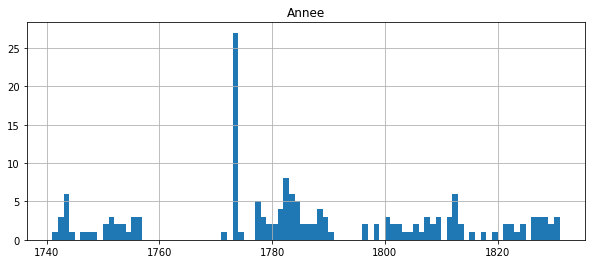

In [8]:
nbins = int(df['Annee'].max() - df['Annee'].min())
#nbins
df.hist('Annee', bins = nbins, figsize = (10,4))

In [9]:
df_help = df.groupby(['Annee'])['Savant'].count().reset_index().rename(columns = {'Savant' : 'count'})

df_pre = df_help[df_help['Annee']<1789]
df_post = df_help[df_help['Annee']>=1793]

In [10]:
from scipy.stats import ttest_ind

ttest_ind(df_pre['count'].array, df_post['count'].array)

Ttest_indResult(statistic=1.5764299842955556, pvalue=0.12066182417266066)

## b. Length of the eulogies

In [9]:
side_info(df)

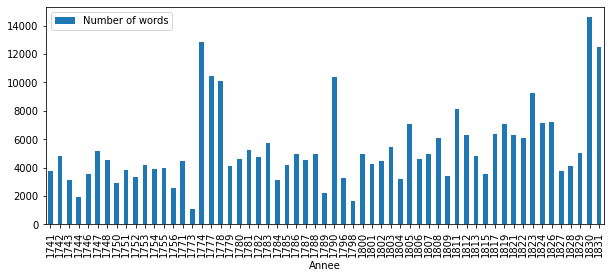

In [12]:
nbr_words = nbr_words(df, evol = True)

In [13]:
nbr_words_pre = nbr_words[nbr_words['Annee']<1793]
nbr_words_post = nbr_words[nbr_words['Annee']>=1793]

ttest_ind(nbr_words_pre['Number of words'].array, nbr_words_post['Number of words'].array)

Ttest_indResult(statistic=-1.5734697836934994, pvalue=0.12114486985407365)

## c. Average word length

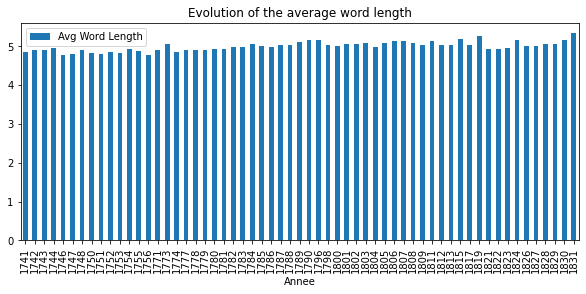

In [14]:
avg_words = avg_word_length(df, evol = True)

In [15]:
avg_words_pre = avg_words[avg_words['Annee']<1793]
avg_words_post = avg_words[avg_words['Annee']>=1793]

ttest_ind(avg_words_pre['Avg Word Length'].array, avg_words_post['Avg Word Length'].array)

Ttest_indResult(statistic=-6.159123370222469, pvalue=7.882208713746585e-08)

## d. Average sentence length

100%|███████████████████████████████████████| 167/167 [00:00<00:00, 1428.27it/s]


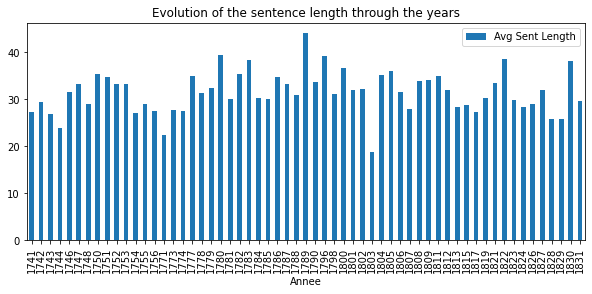

In [16]:
avg_sentence = avg_sentence(df, evol = True)

In [17]:
avg_sentence_pre = avg_sentence[avg_sentence['Annee']<1793]
avg_sentence_post = avg_sentence[avg_sentence['Annee']>=1793]

ttest_ind(avg_sentence_pre['Avg Sent Length'].array, avg_sentence_post['Avg Sent Length'].array)

Ttest_indResult(statistic=0.08408470678034179, pvalue=0.9332837077008933)

## e. Use of first person

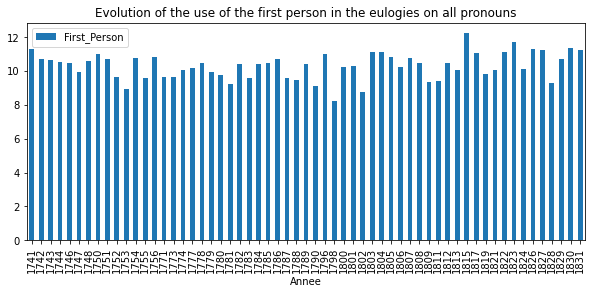

In [18]:
fst_person = first_person(df)

In [19]:
fst_person_pre = fst_person[fst_person['Annee']<1793]
fst_person_post = fst_person[fst_person['Annee']>=1793]

ttest_ind(fst_person_pre['First_Person'].array, fst_person_post['First_Person'].array)

Ttest_indResult(statistic=-1.6883379727768713, pvalue=0.09681093482786082)

## f. Use of modals

100%|███████████████████████████████████████| 167/167 [00:00<00:00, 1145.15it/s]


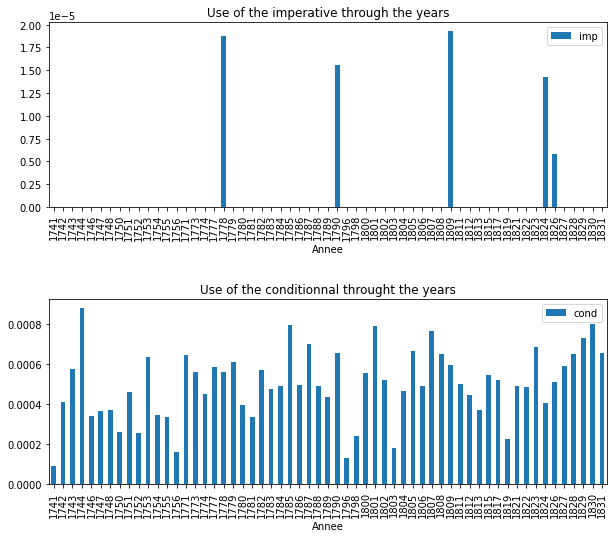

In [36]:
pci = cond_imperative(df)

In [51]:
c_adv = count_adverbs(df)

100%|█████████████████████████████████████████| 168/168 [00:39<00:00,  4.30it/s]


In [52]:
c_adv.sort_values(by = 'Number', ascending = False, inplace = True)
c_adv.reset_index(inplace = True)
c_adv.pop('index')
c_adv

,index,Adverb,Number
0,354,plus,6416
1,303,ne,5910
2,333,pas,3436
3,297,n,2038
4,143,encore,1559
...,...,...,...
497,221,incontinent,1
498,223,indiffremment,1
499,375,prliminairement,1
500,225,indiscrtement,1


- si loc 5
- que loc 52
- qu loc 83
- rien
- voilà 95
- voici 150
- minnement 183
- avec 196
- vice 220


In [45]:
c_adv_pc = pd.read_csv('./../../Data/Results/Adverbs.csv')

In [476]:
c_adv_pc.to_csv('./../../Data/Results/Adverbs.csv', index=False)

## g. Use of past tenses

100%|███████████████████████████████████████| 149/149 [00:00<00:00, 2905.39it/s]


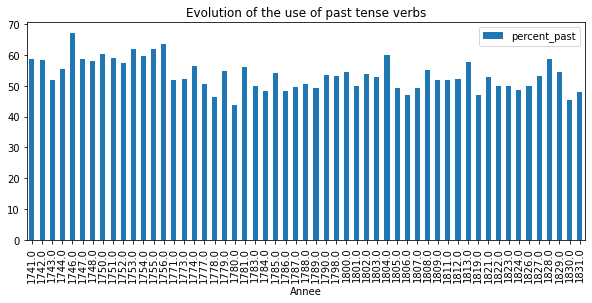

In [20]:
past_tense = past_tense(df)

In [21]:
past_tense_pre = past_tense[past_tense['Annee']<1793]
past_tense_post = past_tense[past_tense['Annee']>=1793]

ttest_ind(past_tense_pre['percent_past'].array, past_tense_post['percent_past'].array)

Ttest_indResult(statistic=2.343391393541898, pvalue=0.02289341018742618)

Reject Null Hypothesis the means are statistically different

## h. Starts with a statement on the birth

In [51]:
naissance(df)

In [53]:
df[df['naissance'] == False].shape[0]

49

In [55]:
df[(df['naissance'] == False)&(df['Annee']<1793)].shape[0]

19

In [56]:
df[(df['naissance'] == False)&(df['Annee']>=1793)].shape[0]

30

## i. Use of Proper Names


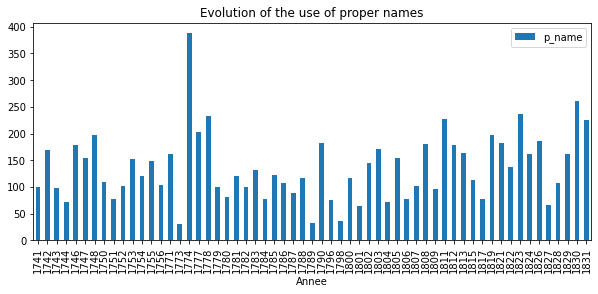

In [14]:
p_n = proper_name(df)

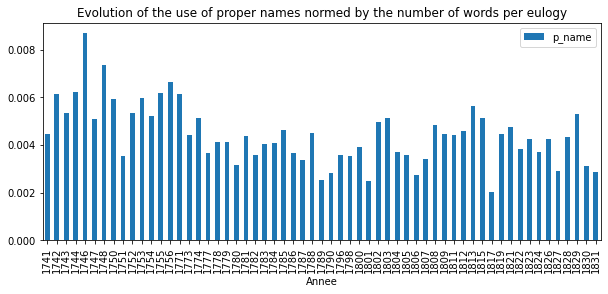

In [15]:
p_norm = proper_name(df, norm = True)

# 3. Second axis : Topic modeling

## Divide the dataframe into sentences

In [180]:
#https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
def chainer(s):
    return list(chain.from_iterable(s.str.split('.')))

#Replace M. for Monsieur with M for the splitting
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('M.', 'M'))
lens = df['Eloge'].str.split('.').map(len)

# create new dataframe, repeating or chaining as appropriate
sent = pd.DataFrame({'Savant': np.repeat(df['Savant'], lens),
                    'Auteur': np.repeat(df['Auteur'], lens),
                     'Annee' : np.repeat(df['Annee'], lens),
                    'Eloge': chainer(df['Eloge'])})

sent = sent[(sent['Eloge'] != ' ') &  (sent['Eloge'] != '') & (sent['Eloge'].str.len()>10)]

In [181]:
sent.head()

,Savant,Auteur,Annee,Eloge
132,Petit,Mairan,1741,François Pourfour Du Petit naquit à Paris le 2...
132,Petit,Mairan,1741,Les personnes qui furent chargées de son éduc...
132,Petit,Mairan,1741,Ce ne fut qu’à force de travail et par les so...
132,Petit,Mairan,1741,Il éprouva les mêmes difficultés en Seconde e...
132,Petit,Mairan,1741,C’est de cette manière laborieuse et tardive ...


In [182]:
#Preprocessing the sentences
rmv_sw(sent, name_col = 'Eloge')
rmv_punkt(sent)
lemmatize(sent, 'no_sw_no_punkt', 'tags')
rmv_digit(sent)

In [183]:
#Only keeping nouns and verbs to avoid noise
nouns_verbs(sent, 'Eloge_lem')

100%|█████████████████████████████████| 18750/18750 [00:00<00:00, 109571.51it/s]


In [184]:
sent.reset_index(inplace = True)
sent.drop('index', axis = 1, inplace = True)
sent.head()

,Savant,Auteur,Annee,Eloge,no_sw,no_sw_no_punkt,tags,Eloge_lem,n_v
0,Petit,Mairan,1741,François Pourfour Du Petit naquit à Paris le 2...,François Pourfour Petit naquit Paris Juin 1664...,François Pourfour Petit naquit Paris Juin 1664...,"[(François, NAM, François), (Pourfour, NAM, Po...",François Pourfour Petit naître Paris juin @car...,naître juin card commerce perdre enfant
1,Petit,Mairan,1741,Les personnes qui furent chargées de son éduc...,Les personnes furent chargées éducation trouvè...,Les personnes furent chargées éducation trouvè...,"[(Les, DET:ART, le), (personnes, NOM, personne...",le personne être charger éducation trouver obs...,personne être charger éducation trouver obstac...
2,Petit,Mairan,1741,Ce ne fut qu’à force de travail et par les so...,fut qu’à force travail soins quelques-uns Maît...,fut qu à force travail soins quelques uns Maît...,"[(fut, VER:simp, être), (qu, VER:pper, qu), (à...",être qu à force travail soin quelque un maître...,être qu force travail soin maître laisser gagn...
3,Petit,Mairan,1741,Il éprouva les mêmes difficultés en Seconde e...,éprouva difficultés Seconde Rhétorique mémoire...,éprouva difficultés Seconde Rhétorique mémoire...,"[(éprouva, VER:simp, éprouver), (difficultés, ...",éprouver difficulté second rhétorique mémoire ...,éprouver difficulté mémoire servir régler poés...
4,Petit,Mairan,1741,C’est de cette manière laborieuse et tardive ...,C’est manière laborieuse tardive Petit vint bo...,C est manière laborieuse tardive Petit vint bo...,"[(C, NUM, C), (est, VER:pres, être), (manière,...",C être manière laborieux tardif Petit venir bo...,être manière venir bout d apprendre latin lett...


In [185]:
#Removing stop words and really short words that might still be here
sent['n_v'] = sent['n_v'].apply(lambda x : ' '.join([elem for elem in x.split() if (elem not in fr_stop and 
                                                                                    len(elem)>2)]))

## Embedding models

I tested different embedding models and chose to stay with the sentence transformer as it was the one working  the best

In [256]:
model_sent = SentenceTransformer('distiluse-base-multilingual-cased-v1')

#modelname = 'flaubert/flaubert_base_cased' 
#flaubert, log = FlaubertModel.from_pretrained(modelname, output_loading_info=True)

#camembert = CamembertModel.from_pretrained('camembert/camembert-base-wikipedia-4gb')

## Bertopic

In [257]:
#Loading Bertopic with embedding model chosen and nr_topics to auto so that topic with more than 0.9 similarity are
#merged
model = BERTopic(embedding_model = model_sent, min_topic_size = 30,
                 nr_topics='auto',calculate_probabilities = True)

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [259]:
topics, probabilities = model.fit_transform(sent.n_v)

In [260]:
pd.set_option('display.max_rows', 200)

In [27]:
#df_info.to_csv('./../../Data/Results/topic_modeling_sentence.csv')
df_info = pd.read_csv('./../../Data/Results/topic_modeling_sentence.csv', index_col = 0)
df_info.head(1)

,Topic,Count,Name
0,-1,9399,-1_faire_homme_pouvoir_donner


In [478]:
#model.save('./../../Data/Results/bert_model')
model = BERTopic.load('./../../Data/Results/bert_model')

In [261]:
df_info = model.get_topic_info()
df_info

,Topic,Count,Name
0,-1,9399,-1_faire_homme_pouvoir_donner
1,0,834,0_planter_espèce_plante_jardin
2,1,792,1_science_naître_progrès_société
3,2,693,2_card_année_publier_mémoire
4,3,618,3_fil_père_fils_famille
5,4,551,4_travail_temps_air_homme
6,5,532,5_astronome_astronomie_soleil_mouvement
7,6,508,6_médecin_médeciner_maladie_remède
8,7,390,7_prince_roi_duc_vouloir
9,8,303,8_euler_équation_solution_calcul


## Hierarchical clusterical

In [277]:
#Manually creating topics
topic_science = [0, 5, 6, 8 ,9, 12, 13, 14, 15, 18, 19, 32, 37, 46, ]
topic_devoir = [1, 4]
topic_methode = [24, 27, 28, 38, ]
topic_famille = [3]
topic_politique = [7, 10, 22, 43, 46, 48]
topic_memoire = [2, 11, 26, 44]
topic_education = [16, 23]
topic_qualite = [17]
topic_jsp = [20, 42]
topic_vie = [21]
topic_religion = [25, 50]
topic_voyage = [29, 39]
topic_mort = [30, 31]
topic_art = [33, 35]
topic_verite = [34]
topic_amitie = [36, 51]
topic_oral = [40, ]
topic_materiaux = [41, 49]
topic_caractere = [45]

In [278]:
topic_dict = {'science' : topic_science, 'devoir' : topic_devoir, 'methode' : topic_methode, 'famille' : topic_famille,
             'politique' : topic_politique, 'memoire' : topic_memoire, 'education' : topic_education, 'qualite' :
             topic_qualite, 'jsp' : topic_jsp, 'vie' : topic_vie, 'religion' : topic_religion, 'voyage' : topic_voyage,
             'mort' : topic_mort, 'art' : topic_art, 'verite' : topic_verite, 'amitie' : topic_amitie, 'oral' :
             topic_oral, 'materiaux' : topic_materiaux, 'caractere' : topic_caractere}

In [477]:
model.visualize_hierarchy()

## Topics over time

In [30]:
bins = sent.Annee.unique().shape[0]

NameError: name 'sent' is not defined

In [272]:
topics_over_time = model.topics_over_time(sent.n_v, topics, sent.Annee, nr_bins=bins)
topics_over_time

,Topic,Words,Frequency,Timestamp
0,-1,"faire, card, voir, savoir, partir",163,1740.910
1,0,"côté, planter, jardin, nerf, anatomiste",12,1740.910
2,1,"science, hôpital, médecin, docte, retoucher",9,1740.910
3,2,"card, mois, moi, année, janvier",30,1740.910
4,3,"fil, fils, père, mariage, marier",9,1740.910
...,...,...,...,...
1438,45,"imagination, léna, esprit, âme, ltalie",6,1829.475
1439,46,"révolution, prospérité, signer, quoiqu, manife...",2,1829.475
1440,47,"électricité, tonnerre, analogie, attouchement,...",23,1829.475
1441,49,"cristal, section, midi, pression, cristaux",8,1829.475


In [273]:
model.visualize_topics_over_time(topics_over_time)

## Structure of an eulogy

In [279]:
df_top = pd.DataFrame({'Topic': topics, 'Document': sent.n_v, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,
                      'Savant' : sent.Savant, 'Auteur' : sent.Auteur})
df_top

,Topic,Document,Eloge,Annee,Savant,Auteur
0,2,naître juin card commerce perdre enfant,François Pourfour Du Petit naquit à Paris le 2...,1741,Petit,Mairan
1,-1,charger éducation trouver obstacle étude défau...,Les personnes qui furent chargées de son éduc...,1741,Petit,Mairan
2,-1,force travail soin maître gagner affection fai...,Ce ne fut qu’à force de travail et par les so...,1741,Petit,Mairan
3,-1,éprouver difficulté mémoire servir régler poés...,Il éprouva les mêmes difficultés en Seconde e...,1741,Petit,Mairan
4,14,manière venir bout apprendre latin lettrer pou...,C’est de cette manière laborieuse et tardive ...,1741,Petit,Mairan
...,...,...,...,...,...,...
18745,4,réfléchir immensité perte reconnaîtraje saurer...,En réfléchissant à l'immensité d'une telle pe...,1831,Volta,Arago
18746,1,messieurs méprendre sentiment craindre aujourd...,"Quant à moi, Messieurs, qui n'ai jamais pu me...",1831,Volta,Arago
18747,-1,moment rêverie passer revoir travail habitude ...,"Dans ces moments de douce rêverie, où, passan...",1831,Volta,Arago
18748,-1,placer associer étranger mourir volter remplir,"La place d'associé étranger, que la mort de V...",1831,Volta,Arago


In [280]:
def major_topic(topic, ls = topic_dict):
    for idx, entri in enumerate(ls.items()) :
        if topic in entri[1] :
            return idx ,entri[0]
    return topic, 'outlier'

In [281]:
df_top['Higher_Topic'] = df_top['Topic'].apply(lambda x : major_topic(x))

In [282]:
df_top.head()

,Topic,Document,Eloge,Annee,Savant,Auteur,Higher_Topic
0,2,naître juin card commerce perdre enfant,François Pourfour Du Petit naquit à Paris le 2...,1741,Petit,Mairan,"(5, memoire)"
1,-1,charger éducation trouver obstacle étude défau...,Les personnes qui furent chargées de son éduc...,1741,Petit,Mairan,"(-1, outlier)"
2,-1,force travail soin maître gagner affection fai...,Ce ne fut qu’à force de travail et par les so...,1741,Petit,Mairan,"(-1, outlier)"
3,-1,éprouver difficulté mémoire servir régler poés...,Il éprouva les mêmes difficultés en Seconde e...,1741,Petit,Mairan,"(-1, outlier)"
4,14,manière venir bout apprendre latin lettrer pou...,C’est de cette manière laborieuse et tardive ...,1741,Petit,Mairan,"(0, science)"


In [479]:
#df_top.to_csv('./../../Data/Results/df_with_topic.csv', index = False)
df_top = pd.read_csv('./../../Data/Results/df_with_topic.csv')

In [283]:
#df_top['Tuple_topic_sent'] = df_top.apply(lambda row : (row['Eloge'], row['Topic']), axis = 1)
df_top['Tuple_topic_sent'] = df_top.apply(lambda row : (row['Eloge'], row['Higher_Topic']), axis = 1)

reconstruct = df_top.groupby(['Savant', 'Auteur', 'Annee'])['Tuple_topic_sent'].apply(list).reset_index()
df_sent = df.merge(reconstruct, on = ['Savant', 'Annee', 'Auteur'])
df_sent['Eloge'] = df_sent['Eloge'].apply(lambda x : x.split('.'))
df_sent['Tuple_topic_sent'] = df_sent.apply(lambda row :sorted(row['Tuple_topic_sent'], 
                                                                         key=lambda x: row['Eloge'].index(x[0])),
                                                               axis = 1)

In [288]:
for sentence, topic in df_sent['Tuple_topic_sent'][34]:
    #print(colors[3*topic] + df_info.loc[topic+1]['Name'] + '  --->' + sentence)
    print(colors[3*topic[0]] + topic[1] + '   --->' + sentence)

 devoir   --->Il est mort en 1760, âgé de quatre-vingts ans, après avoir professé la médecine à Turin pendant quarante-cinq ans
 devoir   ---> Il fut longtemps à la tête du collège de médecine de cette ville, et l’on y bâtit, en 1715, un amphithéâtre pour servir aux démonstrations de cet anatomiste, qui dès lors était célèbre en Italie
 science   --->  Observateur infatigable, ses leçons et une pratique de médecine très étendue ne l’empêchèrent pas de publier un grand nombre d’ouvrages
 outlier   ---> Mais il eut le malheur d’avoir pour adversaires M Morgagni et Haller
 outlier   ---> Ils l’ont accusé de s’être livré à son imagination, lorsqu’il fallait ne se servir que de ses yeux ; et d’avoir quelquefois, en donnant aux parties, non leurs véritables formes, mais des formes plus pittoresques, décrit les objets, moins tels qu’ils étaient, que tels qu’il voulait qu’ils sussent
 outlier   --->  Cependant ses ouvrages renferment des observations utiles, et il a laissé à sa patrie d’excell

In [44]:
for sentence, topic in df_sent['Tuple_topic_sent'][132]:
    print(colors[3*topic] + str(topic) + '  --->' + sentence)

 -1  --->L'histoire de cette longue suite d'hommes de mérite qui ont appartenu à l'Académie des Sciences pendant les cent trente années de son existence, est riche en instructions de plus d'un genre
 -1  ---> Ce n'est pas seulement le spectacle imposant des travaux utiles, des grandes découvertes de ces hommes célèbres qui nous intéresse ; nous prenons encore un plaisir particulier à faire avec eux une connaissance intime ; la simplicité de leurs múurs, la sérénité de leur vie passée loin du monde et de ses agitations, ont quelque chose de touchant, et les sciences, déjà si respectables par leur utilité générale, le deviennent davantage encore quand on voit à quel point elles rendent heureux ceux qui ne vivent que pour elles
 -1  ---> Les savants de notre âge n'ont pas tous joui de ce bonheur ; de grands changements dans l'Etat leur ont ouvert une nouvelle lice ; il en est qui se sont laissés entraîner sur le théâtre tumultueux des affaires, séduits par l'espoir de rendre à leurs conte

## WRONG BERTOPIC

In [35]:


# Create topic model
model = BERTopic(language ='French', nr_topics='auto',calculate_probabilities = True, 
                 n_gram_range = (1, 3))


In [36]:
topics, probabilities = model.fit_transform(sent.n_v, embeddings_n_v)
#topics, probabilities = model.fit_transform(sent.n_v)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

In [37]:
#https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6

import umap
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=10, 
                            metric='cosine', random_state = 42).fit_transform(embeddings_n_v)


#umap_embeddings = umap.UMAP(n_neighbors=15, 
 #                           n_components=10, 
  #                          metric='cosine', random_state = 42).fit_transform(sent.n_v)

In [38]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=20,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

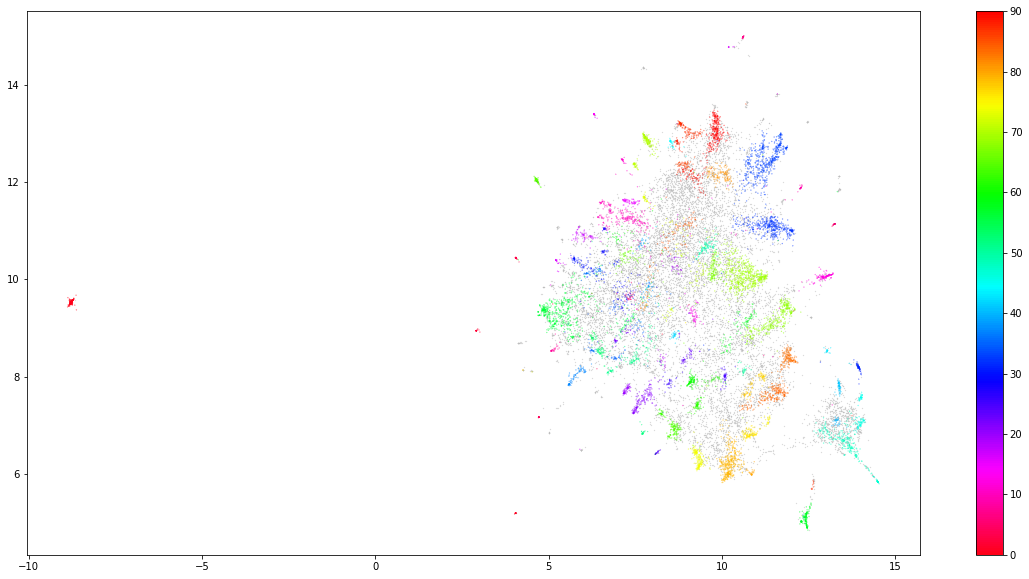

In [39]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings_n_v)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [217]:
result.to_csv('./../../Data/Results/topic_modeling_results.csv')

In [165]:
clustered.labels

1        49
4        63
6        73
8        50
10       50
         ..
23138    92
23141    31
23142    73
23144    65
23147     0
Name: labels, Length: 11285, dtype: int64

In [166]:
for clust in clustered.labels.unique():
    print(colors[clust] + 'Cluster ' + str(clust))

 Cluster 49
 Cluster 63
 Cluster 73
 Cluster 50
 Cluster 56
 Cluster 39
 Cluster 86
 Cluster 18
 Cluster 13
 Cluster 26
 Cluster 31
 Cluster 90
 Cluster 89
 Cluster 81
 Cluster 61
 Cluster 78
 Cluster 0
 Cluster 14
 Cluster 80
 Cluster 34
 Cluster 42
 Cluster 23
 Cluster 7
 Cluster 32
 Cluster 60
 Cluster 38
 Cluster 83
 Cluster 64
 Cluster 2
 Cluster 54
 Cluster 82
 Cluster 29
 Cluster 92
 Cluster 48
 Cluster 46
 Cluster 75
 Cluster 72
 Cluster 41
 Cluster 67
 Cluster 71
 Cluster 40
 Cluster 35
 Cluster 21
 Cluster 68
 Cluster 6
 Cluster 24
 Cluster 77
 Cluster 51
 Cluster 43
 Cluster 5
 Cluster 17
 Cluster 33
 Cluster 37
 Cluster 8
 Cluster 69
 Cluster 70
 Cluster 53
 Cluster 12
 Cluster 55
 Cluster 57
 Cluster 45
 Cluster 65
 Cluster 20
 Cluster 79
 Cluster 30
 Cluster 44
 Cluster 52
 Cluster 16
 Cluster 76
 Cluster 28
 Cluster 91
 Cluster 27
 Cluster 10
 Cluster 25
 Cluster 22
 Cluster 58
 Cluster 47
 Cluster 85
 Cluster 88
 Cluster 87
 Cluster 66
 Cluster 84
 Cluster 19
 Cluster 3

In [54]:
top_n_words[1][:20]

[('matériau', 0.6696598079369797),
 ('matériaux', 0.3782229729327038),
 ('rassembler', 0.06896809572470068),
 ('papier', 0.05065275943151416),
 ('année', 0.04634863059494898),
 ('ouvrage', 0.043934947343541926),
 ('fournir', 0.03976514954698105),
 ('travail', 0.03480062316624278),
 ('traiter', 0.03373726673589902),
 ('réunir', 0.03074514971888469),
 ('livre', 0.029509808985478607),
 ('temps', 0.02866485810164464),
 ('faire', 0.028622164188919493),
 ('trouver', 0.0284834827606081),
 ('publier', 0.027894504484437522),
 ('livrer', 0.02654413694134768),
 ('fabrication', 0.025878066185252863),
 ('disposition', 0.02523123999144207),
 ('employer', 0.02459917927421015),
 ('esquisser', 0.024278369922380704)]

In [40]:
docs_df = pd.DataFrame({ 'Doc' : sent.n_v.tolist(),'Annee' :sent.Annee.tolist(), 'Eloge' : sent.Eloge.tolist(),
                       'Savant' : sent.Savant.tolist(), 'Auteur' : sent.Auteur.tolist()})
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_df.head()
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [41]:
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(sent))

In [42]:
top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,11542
70,69,607
34,33,527
57,56,496
33,32,415
80,79,380
69,68,340
91,90,284
1,0,282
11,10,268


In [215]:
topic_sizes.to_csv('./../../Data/Results/topic_sizes.csv')
docs_df.to_csv('./../../Data/Results/topic_modeling.csv')

In [39]:
topic_sizes.shape

(94, 2)

In [43]:
from sklearn.metrics.pairwise import cosine_similarity


for i in range(20):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(sent)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
0,-1,11802
52,51,607
22,21,527
39,38,496
21,20,415
60,59,380
51,50,340
71,70,284
1,0,282
5,4,268


In [44]:
topic_sizes.shape

(72, 2)

In [55]:
top_n_words[38][:20]

[('remplir', 0.07153951905466276),
 ('confrère', 0.05432562646321104),
 ('éloge', 0.05068697121662731),
 ('placer', 0.04825587372216253),
 ('chancelier', 0.039673338281348794),
 ('devenir', 0.03774047763166891),
 ('entrer', 0.037694386605127105),
 ('partie', 0.0364720205220234),
 ('recevoir', 0.03640966498626231),
 ('polignac', 0.035638192939687084),
 ('prix', 0.033565298344178075),
 ('aller', 0.03157019557139941),
 ('arriver', 0.030899855824247015),
 ('occuper', 0.030397960117815537),
 ('planer', 0.03023432554365903),
 ('faire', 0.030090260806656506),
 ('dispute', 0.029492781750531508),
 ('répondre', 0.029051788331365087),
 ('partir', 0.02880697207259693),
 ('luynes', 0.02825177369505124)]

In [218]:
import json
with open('./../../Data/top_words.json', 'w') as fp:
    json.dump(top_n_words, fp)

In [194]:
docs_df

,Doc,Annee,Eloge,Savant,Auteur,Topic,Doc_ID
0,sénateur comte l empire officier légion d honn...,1813.0,"Louis-Antoine de Bougainville, sénateur, comte...",Bougainville,Delambre,34,0
1,fils|fil fil d notaire échevin descendre d fam...,1813.0,"Il était fils d'un notaire, échevin de Paris,...",Bougainville,Delambre,10,1
2,navigateur officier terre mer associer l scien...,1813.0,"Navigateur célèbre, officier - général de ter...",Bougainville,Delambre,-1,2
3,collège faire remarquer aptitude lettrer science,1813.0,"Encore au collège, il se faisait déjà remarque...",Bougainville,Delambre,-1,3
4,professeur expliquer jour phase lune position ...,1813.0,Son professeur expliquait un jour les phases ...,Bougainville,Delambre,50,4
...,...,...,...,...,...,...,...
22080,lecture d l odyssée d,1800.0,"Sa lecture favorite était celle d'Homère, l'O...",Borda,Lefevre-Gineau,-1,22080
22081,conversation raison s mêler saillie,1800.0,Sa conversation était agréable et instructiv...,Borda,Lefevre-Gineau,39,22081
22082,cúur aimer inspirer rattachement respect,1800.0,Son cúur était aimant et facile ; il inspira...,Borda,Lefevre-Gineau,-1,22082
22083,mettre prix célébrité gloire d avoir être homme,1800.0,"Il mettait peu de prix à la célébrité, mais ...",Borda,Lefevre-Gineau,-1,22083


In [52]:
docs_df['Tuple_topic_sent'] = docs_df.apply(lambda row : (row['Eloge'], row['Topic']), axis = 1)

In [53]:
reconstruct = docs_df.groupby(['Savant', 'Auteur', 'Annee'])['Tuple_topic_sent'].apply(list).reset_index()

In [54]:
df_sent = df.merge(reconstruct, on = ['Savant', 'Annee', 'Auteur'])

In [55]:
df_sent['Tuple_topic_sent'] = df_sent.apply(lambda row :sorted(row['Tuple_topic_sent'], 
                                                                         key=lambda x: row['Eloge'].index(x[0])),
                                                               axis = 1)

In [23]:
import sys

colors = []
for i in range(0, 16):
    for j in range(0, 16):
        code = str(i * 16 + j)
        sys.stdout.write(u"\u001b[38;5;" + code + "m " + code.ljust(4))
        colors.append(u"\u001b[38;5;" + code + "m ")
    print(u"\u001b[0m")

 0    1    2    3    4    5    6    7    8    9    10   11   12   13   14   15  
 16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31  
 32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47  
 48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63  
 64   65   66   67   68   69   70   71   72   73   74   75   76   77   78   79  
 80   81   82   83   84   85   86   87   88   89   90   91   92   93   94   95  
 96   97   98   99   100  101  102  103  104  105  106  107  108  109  110  111 
 112  113  114  115  116  117  118  119  120  121  122  123  124  125  126  127 
 128  129  130  131  132  133  134  135  136  137  138  139  140  141  142  143 
 144  145  146  147  148  149  150  151  152  153  154  155  156  157  158  159 
 160  161  162  163  164  165  166  167  168  169  170  171  172  173  174  175 
 176  177  178  179  180  181  182  183  184  185  186  187  188  189  190  191 
 192  193  194  195  196  19

In [57]:
test_print = df_sent['Tuple_topic_sent'][0]
test_print

[("Louis-Antoine de Bougainville, sénateur, comte l'empire, grand - officier de la légion d'honneur, naquit à Paris, le 11 novembre 1729",
  -1),
 ('', 0),
 (" Il était fils d'un notaire, échevin de Paris, et descendait d'une ancienne famille de Picardie",
  35),
 (" Navigateur célèbre, officier - général de terre et de mer, associé libre de l'Académie des sciences, membre de l'Institut et du bureau des longitudes, tant de titres divers qu'il ne dut qu'à lui-même, et qui furent la récompense de longs travaux et d'actions d'éclat, font déjà un assez bel éloge, et prouvent que celui qui sut les mériter n'était en aucun genre un homme ordinaire",
  -1),
 ('Encore au collège, il se faisait déjà remarquer par une aptitude égale pour les lettres et pour les sciences',
  -1),
 (' Son professeur expliquait un jour les phases de la lune et les diverses positions du croissant ; pour graver ces notions dans la mémoire de ses auditeurs, il leur citait deux vers latins',
  46),
 (' Le jeune Bougain

In [143]:
for sentence, topic in test_print:
    print(colors[topic] + str(topic) + '  --->' + sentence)

 -1  --->Louis-Antoine de Bougainville, sénateur, comte l'empire, grand - officier de la légion d'honneur, naquit à Paris, le 11 novembre 1729
 0  --->
 35  ---> Il était fils d'un notaire, échevin de Paris, et descendait d'une ancienne famille de Picardie
 -1  ---> Navigateur célèbre, officier - général de terre et de mer, associé libre de l'Académie des sciences, membre de l'Institut et du bureau des longitudes, tant de titres divers qu'il ne dut qu'à lui-même, et qui furent la récompense de longs travaux et d'actions d'éclat, font déjà un assez bel éloge, et prouvent que celui qui sut les mériter n'était en aucun genre un homme ordinaire
 -1  --->Encore au collège, il se faisait déjà remarquer par une aptitude égale pour les lettres et pour les sciences
 46  ---> Son professeur expliquait un jour les phases de la lune et les diverses positions du croissant ; pour graver ces notions dans la mémoire de ses auditeurs, il leur citait deux vers latins
 -1  ---> Le jeune Bougainville se p

In [150]:
top_n_words[58][:20]

[('science', 0.20321595537303438),
 ('progrès', 0.03857673511909464),
 ('être', 0.03768229938391497),
 ('qu', 0.032544155172536664),
 ('homme', 0.03208222593267758),
 ('avoir', 0.026929214435283573),
 ('faire', 0.026864094692329477),
 ('histoire', 0.025158216083782124),
 ('pouvoir', 0.024905770830642566),
 ('découvrir', 0.02470108784075995),
 ('travail', 0.022664559846602084),
 ('vérité', 0.02260851582024733),
 ('esprit', 0.022199130429922564),
 ('génie', 0.01844619870142637),
 ('temps', 0.018420750335552207),
 ('devoir', 0.0169500582118842),
 ('donner', 0.016191168765759996),
 ('gloire', 0.016146766392747237),
 ('utilité', 0.015409305900676008),
 ('rendre', 0.0147505917028798)]

In [148]:
for sentence, topic in df_sent['Tuple_topic_sent'][30]:
    print(colors[topic] + str(topic) + '  --->' + sentence)

 -1  --->Edme Mariotte naquit à Dijon, ou du moins il y passa une partie de sa vie
 0  --->
 0  ---> M
 0  ---> M
 0  ---> M
 16  ---> C’est de Dijon qu’il a daté plusieurs de ses ouvrages, et entre autres celui où il prouve que le nerf optique n’est pas l’organe de la vue
 -1  ---> Peu de villes ont produit un plus grand nombre d’hommes de mérite, parce que peu de villes ont senti avec autant d’enthousiasme le prix des talents, et leur ont autant décerné d’hommages publics [Savoir si ce que je dis ici de la ville de Dijon est vrai ou non]
 -1  --->  Mariotte est le premier philosophe français qui se soit livré à la physique expérimentale
 -1  ---> D’un côté, il était assez profond dans la géométrie pour savoir faire usage des découvertes des géomètres ; de l’autre, il avait l’esprit assez philosophique pour ne tenter que les expériences qui pouvaient servir à faire mieux connaître la nature ; en sorte qu'il sut déduire de ses expériences, avec une égale sagacité, ou des théories nouve

In [152]:
for sentence, topic in df_sent['Tuple_topic_sent'][70]:
    print(colors[topic] + str(topic) + '  --->' + sentence)

 28  --->Louis Élisabeth de la Vergne, comte de Tressan, lieutenant général des armées du roi, commandeur de l’ordre de saint-Lazare, l’un des quarante de l’Académie française, associé libre de celle des sciences ; de la société royale de Londres ; des Académies de Berlin et d’Édimbourg, naquit au Mans, le 4 novembre 1705, de François de la Vergne-Tressan et de Madeleine Brulart de Genlis
 0  --->
 0  ---> M
 0  ---> M
 0  ---> M
 0  ---> M
 0  ---> M
 0  ---> M
 -1  ---> La maison de la Vergne était établie en Languedoc, lorsque Simon de Montfort, à la tête d’une troupe de brigands que l’amour du pillage et le fanatisme rassemblaient sous sa bannière, vint convertir et ravager cette belle province
 70  ---> Les la Vergne, fidèles à leur prince Raimond, comte de Toulouse, prirent avec lui la défense de son peuple : mais la férocité l’emporta sur le courage, plus de trois cents mille habitants, paisibles et désarmés, furent la proie des soldats et des bourreaux, tandis que les biens et 

In [158]:
top_n_words[14][:20]

[('mémoire', 0.39818396448003973),
 ('imprimer', 0.06488732897499772),
 ('souvenir', 0.06463629668635076),
 ('avoir', 0.04229386220289431),
 ('partie', 0.03827555447327808),
 ('oublier', 0.03723476857943689),
 ('donner', 0.036036739728993426),
 ('être', 0.033927840893856774),
 ('collection', 0.02997396302987066),
 ('volume', 0.02971788707997089),
 ('publier', 0.029431510335413906),
 ('faire', 0.02927934644985865),
 ('voir', 0.02858170771843142),
 ('rappeler', 0.026252234944440168),
 ('ouvrage', 0.026151845003619546),
 ('qu', 0.025722172420222386),
 ('recueil', 0.022398405244616188),
 ('objet', 0.02198335083999575),
 ('matière', 0.021121499604964764),
 ('homme', 0.020670018960523676)]

In [174]:
set_top = set()
for _, topic in test_print :
    set_top.add(topic)

for topic in set_top:
    print(top_n_words[topic][:10])
    print('\n')

[('summos', 2.0005307848061253), ('exe', 2.0005307848061253), ('souhaiter', 1.3567556198324853), ('border', 1.1954604466590957), ('prix', 0.9469591529934598), ('œuvrer', 0.0), ('enfumer', 0.0), ('engorgement', 0.0), ('engloutir', 0.0), ('engendrer', 0.0)]


[('matériau', 0.6618465116495704), ('matériaux', 0.373262088843281), ('rassembler', 0.074026855961441), ('papier', 0.05426234110045695), ('ouvrage', 0.04750832006726409), ('année', 0.04380707066427243), ('travail', 0.037711192544145185), ('qu', 0.0370518591130426), ('traiter', 0.03634313679637598), ('être', 0.03478956215795108)]


[('année', 0.5277080515328206), ('vie', 0.055334556996880134), ('être', 0.05322808268299745), ('avoir', 0.038122927634807166), ('travail', 0.032192785954338145), ('suivre', 0.030171680954076574), ('qu', 0.027676193141071948), ('an', 0.024685550194160376), ('jour', 0.02462006313564479), ('saison', 0.024026459341850444)]


[('institut', 0.7737419386680578), ('académie', 0.22252628770293512), ('institution', 

In [60]:
test_print_1 = df_sent['Tuple_topic_sent'][1]


In [61]:
for sent, topic in test_print_1:
    print(colors[topic] + sent)

 Névil Maskelyne, docteur en théologie, membre du collège de la Trinité à Cambridge, de la Société royale de Londres, l'un des huit associés étrangers de l'Académie des Sciences et de la Classe des Sciences physiques et mathématiques de l'Institut royal, astronome royal d'Angleterre était né à Londres le 6 octobre 1732, d'une ancienne famille établie depuis longtemps dans la partie occidentale de l'Angleterre
 
  M
  M
  M
  M
  M
  M
  M
  M
  M
  M
  M
  M
  M
  Maskelyne
  M
  Il fut placé à l'âge de neuf ans à l'école de Westminster, où il ne tarda guère à se distinguer
  Il montra de bonne heure son goût pour l'optique et l'astronomie ; mais ce qui décida sa vocation, ce fut l'éclipsé de soleil de 1748, qui fut de dix doigts à Londres
  Il est à remarquer que cette éclipse produisit le même effet sur l'esprit de Lalande, plus âgé de trois mois seulement que Maskelyne ; et l'on peut dire avec vérité que jamais phénomène céleste ne fut plus utile à la science que l'éclipsé qui lui d

In [136]:
top_n_words[test_print_1[0][1]][:10]

[('card', 0.23779263589947455),
 ('moi', 0.04487195005106902),
 ('mois', 0.044543243264461546),
 ('naître', 0.03410610713869314),
 ('année', 0.03287738091163235),
 ('être', 0.03157842945915868),
 ('an', 0.02972283519152572),
 ('science', 0.029487347654037002),
 ('mourir', 0.029034146370016653),
 ('mémoire', 0.025537598311610243)]

In [142]:
for topic in range(topic_sizes.shape[0]):
    print(colors[topic] + 'Topic ' + str(topic) +' in color')

 Topic 0 in color
 Topic 1 in color
 Topic 2 in color
 Topic 3 in color
 Topic 4 in color
 Topic 5 in color
 Topic 6 in color
 Topic 7 in color
 Topic 8 in color
 Topic 9 in color
 Topic 10 in color
 Topic 11 in color
 Topic 12 in color
 Topic 13 in color
 Topic 14 in color
 Topic 15 in color
 Topic 16 in color
 Topic 17 in color
 Topic 18 in color
 Topic 19 in color
 Topic 20 in color
 Topic 21 in color
 Topic 22 in color
 Topic 23 in color
 Topic 24 in color
 Topic 25 in color
 Topic 26 in color
 Topic 27 in color
 Topic 28 in color
 Topic 29 in color
 Topic 30 in color
 Topic 31 in color
 Topic 32 in color
 Topic 33 in color
 Topic 34 in color
 Topic 35 in color
 Topic 36 in color
 Topic 37 in color
 Topic 38 in color
 Topic 39 in color
 Topic 40 in color
 Topic 41 in color
 Topic 42 in color
 Topic 43 in color
 Topic 44 in color
 Topic 45 in color
 Topic 46 in color
 Topic 47 in color
 Topic 48 in color
 Topic 49 in color
 Topic 50 in color
 Topic 51 in color
 Topic 52 in color
 To

In [62]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [126]:
df_help = df_sent.copy()
#df_help['Topic'] = df_help['Tuple_topic_sent'].apply(lambda x : list(set([elem[1] for elem in x])))
df_help = df_help.explode('Tuple_topic_sent', ignore_index=True)
df_help['Topic'] = df_help['Tuple_topic_sent'].apply(lambda x : x[1])
df_help

,Savant,Auteur,Annee,Eloge,Tuple_topic_sent,Topic
0,Bougainville,Delambre,1813.0,"Louis-Antoine de Bougainville, sénateur, comte...","(Louis-Antoine de Bougainville, sénateur, comt...",-1
1,Bougainville,Delambre,1813.0,"Louis-Antoine de Bougainville, sénateur, comte...","(, 0)",0
2,Bougainville,Delambre,1813.0,"Louis-Antoine de Bougainville, sénateur, comte...","( Il était fils d'un notaire, échevin de Paris...",35
3,Bougainville,Delambre,1813.0,"Louis-Antoine de Bougainville, sénateur, comte...","( Navigateur célèbre, officier - général de te...",-1
4,Bougainville,Delambre,1813.0,"Louis-Antoine de Bougainville, sénateur, comte...","(Encore au collège, il se faisait déjà remarqu...",-1
...,...,...,...,...,...,...
23143,Borda,Lefevre-Gineau,1800.0,"Jean-Charles Borda, de l'Institut national, de...",( Il aimait les lettres et même la poésie ; m...,56
23144,Borda,Lefevre-Gineau,1800.0,"Jean-Charles Borda, de l'Institut national, de...","( Sa lecture favorite était celle d'Homère, l'...",-1
23145,Borda,Lefevre-Gineau,1800.0,"Jean-Charles Borda, de l'Institut national, de...",( Sa conversation était agréable et instructi...,48
23146,Borda,Lefevre-Gineau,1800.0,"Jean-Charles Borda, de l'Institut national, de...",( Son cúur était aimant et facile ; il inspir...,-1


In [127]:
import seaborn as sns

top = topic_sizes.head(10).Topic.to_list()
top.pop(0)
top.pop(0)
top

[29, 35, 58, 17, 46, 26, 70, 52]

In [128]:
df_topic = df_help[df_help['Topic'].isin(top)]
df_topic

,Savant,Auteur,Annee,Eloge,Tuple_topic_sent,Topic
2,Bougainville,Delambre,1813.0,"Louis-Antoine de Bougainville, sénateur, comte...","( Il était fils d'un notaire, échevin de Paris...",35
5,Bougainville,Delambre,1813.0,"Louis-Antoine de Bougainville, sénateur, comte...",( Son professeur expliquait un jour les phases...,46
19,Bougainville,Delambre,1813.0,"Louis-Antoine de Bougainville, sénateur, comte...","( En 1768, un détachement de cinq mille França...",29
31,Bougainville,Delambre,1813.0,"Louis-Antoine de Bougainville, sénateur, comte...","( La cour de France y songeait en 1763, 29)",29
38,Bougainville,Delambre,1813.0,"Louis-Antoine de Bougainville, sénateur, comte...",( Une excursion au détroit de Magellan lui pro...,17
...,...,...,...,...,...,...
23123,Borda,Lefevre-Gineau,1800.0,"Jean-Charles Borda, de l'Institut national, de...",( C'était donner aux navigateurs un instrument...,46
23124,Borda,Lefevre-Gineau,1800.0,"Jean-Charles Borda, de l'Institut national, de...",( Il décrivit cet instrument dans un ouvrage p...,29
23125,Borda,Lefevre-Gineau,1800.0,"Jean-Charles Borda, de l'Institut national, de...",( Le cercle entier qu'il a fait exécuter plus...,46
23126,Borda,Lefevre-Gineau,1800.0,"Jean-Charles Borda, de l'Institut national, de...",( L'exactitude qu'il donne est due aux mêmes m...,46


In [129]:
df_topic = df_topic.groupby(['Annee', 'Topic']).agg({'Auteur' : 'count'}).rename(columns = {'Auteur' : 'NBR'}).reset_index()
df_topic

,Annee,Topic,NBR
0,1741.0,17,5
1,1741.0,26,9
2,1741.0,29,10
3,1741.0,35,1
4,1741.0,58,2
...,...,...,...
342,1831.0,35,10
343,1831.0,46,1
344,1831.0,52,22
345,1831.0,58,10


In [213]:
df_topic.to_csv('./../../Data/Results/topic_modeling.csv')
df_sent.to_csv('./../../Data/Results/df_sent.csv')

In [131]:
dic = {'17' : 'Botanique', '29' : 'Mort_Publier', '35' : 'Famille', '58' : 'Sciences', '46' : 'Astronomie',
      '52' : 'Chimie', '70' : 'Roi', '26' : 'Médecine'}

Text(0, 0.5, 'Evolution of the top-ten topics')

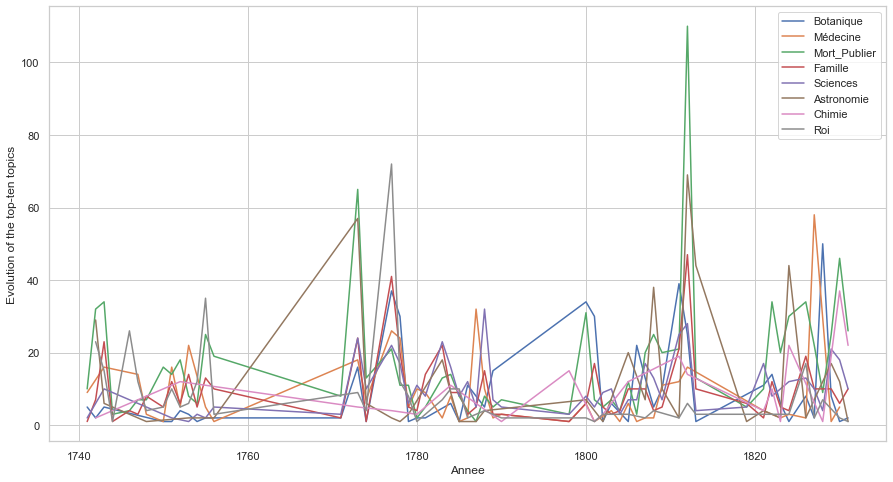

In [151]:
fig, ax = plt.subplots(figsize = (15,8))
leg = []

for top in df_topic['Topic'].unique():
    df_temp = df_topic[df_topic['Topic']==top]
    ax = df_temp.plot(ax=ax, kind='line', x='Annee', y='NBR')
    leg.append(dic[str(top)])

plt.legend(leg)
plt.ylabel('Evolution of the top-ten topics')

In [124]:
dic = {'17' : 'Botanique', '29' : 'Mort_Publier', '35' : 'Famille', '58' : 'Sciences', '46' : 'Astronomie',
      '52' : 'Chimie', '70' : 'Roi', '26' : 'Médecine', '2' : 'Livre'}

In [117]:
df_topic['Topic'].unique()

array([17, 26, 29, 35, 58, 46, 52, 70])

In [164]:
top_n_words[5][:20]

[('loi', 0.4590368811238842),
 ('phénomène', 0.0836235367964336),
 ('examen', 0.065090021629584),
 ('falloir', 0.04914931768094395),
 ('faire', 0.04836369875840237),
 ('système', 0.04081252617803648),
 ('régir', 0.03941720378742565),
 ('donner', 0.0376995328111586),
 ('être', 0.036203192514661975),
 ('irrégularité', 0.03572655992950927),
 ('découvrir', 0.033831786182009556),
 ('esprit', 0.032305297803449366),
 ('qu', 0.03229084174949159),
 ('législation', 0.03223783673837423),
 ('coutume', 0.03173492258248962),
 ('question', 0.031661402498828824),
 ('désordre', 0.030733869928637258),
 ('jouer', 0.030243873966536623),
 ('affinité', 0.029799528271710785),
 ('trouver', 0.02846292756377745)]

In [141]:
top_n_words[71][:20]

[('ministre', 0.3398239258262201),
 ('ministère', 0.04970415521419251),
 ('avoir', 0.03899486681634077),
 ('être', 0.03722487770219231),
 ('affairer', 0.035502968010137505),
 ('qu', 0.03486222289003393),
 ('lettre', 0.030442130843321136),
 ('sceau', 0.024999633587750602),
 ('faire', 0.02486428193836883),
 ('faveur', 0.024445445204777903),
 ('exiger', 0.02327065504438049),
 ('placer', 0.02312434247689285),
 ('seychelles', 0.022960776643273093),
 ('occuper', 0.02286563449549967),
 ('mettre', 0.022670513017769196),
 ('forcer', 0.022185200368992918),
 ('attachement', 0.0218007212674183),
 ('venir', 0.021677733660434143),
 ('partir', 0.021668664967984384),
 ('haine', 0.021570584984051424)]